### Нашей целью будет предсказать индивидуальные медицинские расходы граждан США, 
### оплачиваемые медицинской страховкой.

In [1]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

In [2]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
%matplotlib inline
plt.style.use('seaborn')

In [3]:
load_data = pd.read_csv('data\insurance.zip')

In [4]:
data = load_data.copy()

In [5]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [6]:
TARGET_FEATURE = 'charges'

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [8]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [9]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [10]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Целевой признак нужно конвертировать в целый. Точность тут излишняя.

In [11]:
# data[TARGET_FEATURE] = data[TARGET_FEATURE].round().astype('int')

In [12]:
data.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [13]:
# кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)

# оставшиеся категориальные признаки кодируем с помощью OneHot
# нужно проверить результаты с drop_first и без
data = pd.get_dummies(data, drop_first=False)

In [14]:
data

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,0,1,0,0
1334,18,0,31.920,0,0,2205.98080,1,0,0,0
1335,18,0,36.850,0,0,1629.83350,0,0,1,0
1336,21,0,25.800,0,0,2007.94500,0,0,0,1


In [15]:
features = data.drop(TARGET_FEATURE, axis=1).columns
X, y = data[features], data[TARGET_FEATURE]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Чему равно количество наблюдений в тестовом наборе данных?

In [17]:
X_test.shape[0]

268

In [18]:
# Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()

# Обучаем модель - ищем параметры
lr.fit(X_train, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

Чему равен свободный член (intercept) обученной модели? Ответ округлите до сотых.

In [19]:
round(lr.intercept_, 2)

-12390.8

-11931.22

In [20]:
hd.print_regression_metrics(y_train, y_train_pred, y_test, y_test_pred,
                             show_R2=True, show_MAE=True, show_MAPE=True, show_MSE=True, show_RMSE=True)

*** TRAIN ***
R^2: 0.742
MAE: 4208.235
MAPE: 42.203
MSE: 37277681.702
RMSE: 6105.545

*** TEST ***
R^2: 0.784
MAE: 4181.194
MAPE: 46.888
MSE: 33596915.851
RMSE: 5796.285


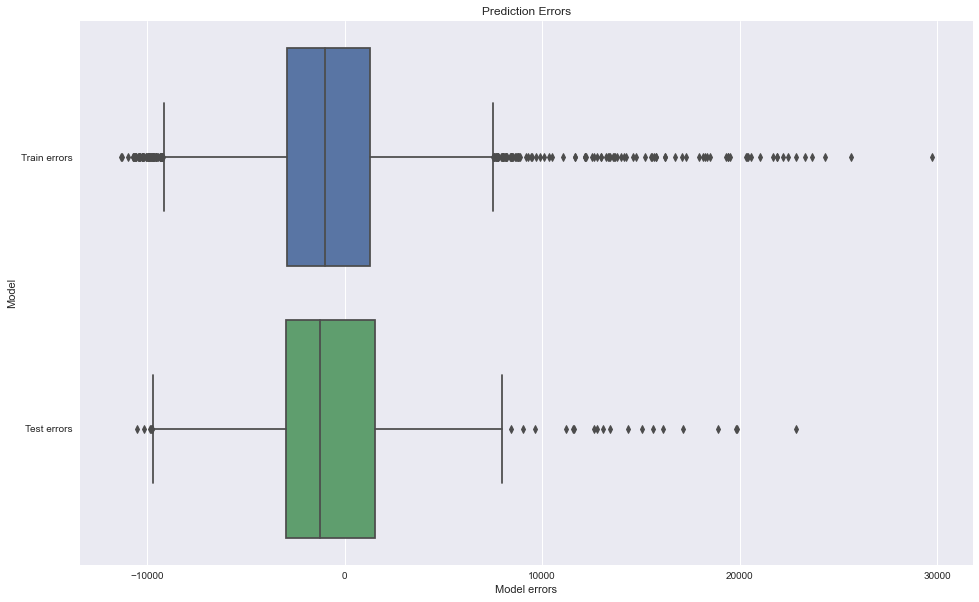

In [21]:
hd.errors_boxplot(y_train, y_train_pred, y_test, y_test_pred)

In [22]:
# Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()

# Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)

# Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

# Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)

# Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1070, 54)
Test shape: (268, 54)


In [23]:
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)

y_train_pred = lr_poly.predict(X_train_scaled_poly)
y_test_pred = lr_poly.predict(X_test_scaled_poly)

hd.print_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
R^2: 0.842
MAE: 2897.052
MAPE: 29.590

*** TEST ***
R^2: 0.867
MAE: 2735.794
MAPE: 30.441


In [24]:
lr_poly.coef_

array([ 1.05586959e+16, -1.66190051e+15, -5.00008349e+15,  1.33440962e+16,
        3.64166659e+15, -1.71792815e+16, -3.85470935e+16, -2.48787113e+16,
       -4.26910240e+16,  8.36000000e+03,  8.86500000e+02,  9.17000000e+02,
       -1.72650000e+03,  1.67000000e+02, -1.05586959e+16, -1.05586959e+16,
       -1.05586959e+16, -1.05586959e+16,  6.98224478e+16,  6.27687500e+02,
       -1.25406250e+03,  2.91437500e+02, -6.81605473e+16, -6.81605473e+16,
       -6.81605473e+16, -6.81605473e+16, -9.64668750e+03,  1.65077344e+03,
        5.48706719e+04,  5.00008349e+15,  5.00008349e+15,  5.00008349e+15,
        5.00008349e+15, -1.97600000e+03, -2.22400000e+03, -1.33440962e+16,
       -1.33440962e+16, -1.33440962e+16, -1.33440962e+16, -6.57752829e+15,
        2.93586170e+15,  2.93586170e+15,  2.93586170e+15,  2.93586170e+15,
       -4.42015916e+16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.28337795e+16,  0.00000000e+00,  0.00000000e+00, -3.65021618e+16,
        0.00000000e+00, -

Постройте линейную регрессию с L1-регуляризацией (Lasso) на полиномиальных признаках. 
В качестве параметра alpha используйте значение по умолчанию, параметр max_iter установите в значение 2000.

In [25]:
# Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(max_iter=2000)

# Обучаем модель 
lasso_lr_poly.fit(X_train_scaled_poly, y_train)

# Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)

# Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)

hd.print_regression_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

*** TRAIN ***
R^2: 0.842
MAE: 2890.473
MAPE: 29.401

*** TEST ***
R^2: 0.867
MAE: 2719.334
MAPE: 30.070


In [26]:
lasso_lr_poly.coef_

array([ 3.24221653e+03, -4.92313816e+02,  5.07612317e+03,  4.58362056e+03,
        1.97928569e+03,  1.88025707e+02, -4.70775218e+02,  5.83657101e+02,
       -2.43543456e+02,  8.29826751e+03,  7.74581954e+02,  8.44448593e+02,
       -1.20775688e+03,  1.34809915e+02, -1.04309726e+03, -0.00000000e+00,
        1.16964229e+03,  1.61765564e+03, -0.00000000e+00,  5.05847740e+02,
       -1.13425152e+03,  2.65796922e+02, -1.22240479e+03,  0.00000000e+00,
        2.36213242e+02, -5.80031340e+02, -8.17963257e+03,  1.29487768e+03,
        5.47148553e+04,  3.58531873e+03,  2.40690210e+03, -9.63549427e+02,
        0.00000000e+00, -1.67464337e+03, -2.05436459e+03,  1.94204864e+03,
        1.95394442e+03, -0.00000000e+00, -1.06364416e+03,  8.00606774e+00,
        5.93688978e+02, -0.00000000e+00, -2.30643423e+02,  1.97933477e+03,
        6.31615519e+02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [27]:
# Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge()

# Обучаем модель 
ridge_lr_poly.fit(X_train_scaled_poly, y_train)

# Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)

# Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)

hd.print_regression_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

*** TRAIN ***
R^2: 0.839
MAE: 2948.804
MAPE: 29.546

*** TEST ***
R^2: 0.863
MAE: 2860.555
MAPE: 31.380


In [28]:
ridge_lr_poly.coef_

array([ 3369.38386245,  -457.59604061,  3655.82413935,  3198.89989857,
        2682.62197133,   199.05715111,  -228.717235  ,   191.94660929,
        -162.28652539,  7548.51142058,   581.66782381,   935.50427948,
        -681.52086519,   663.45387027,  -450.92174702,   438.63623056,
        1406.72601433,  1974.94336458,  -457.59604061,   947.62267378,
        -902.74408745,   739.02044241,  -822.63208356,   302.52583364,
         351.60830856,  -289.09809926, -4274.11806366,  2734.55631801,
       44541.21377369,  3667.33801864,  1719.64618126, -1249.79159858,
        -481.36846198, -1314.96604775, -2172.72264458,  2171.5603185 ,
        1997.18187938,   112.64828732, -1082.49058663,  2682.62197133,
          94.23317954,  -208.05994803,   535.71682279,  2260.73191704,
         199.05715111,     0.        ,     0.        ,     0.        ,
        -228.717235  ,     0.        ,     0.        ,   191.94660928,
           0.        ,  -162.28652539])